# Energy-dependent third-factor STDP

### Idea
<img src=img/3f-stdp.png width="300" />

Based on [*Wyatt et al., 2010: Metabolic Regulation of Neuronal Plasticity by the Energy Sensor AMPK*](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0008996)
<img src=img/wyatt_fig3.png width="600" />
#### TODO
- [] Read references
    + []Guetig et al. (2003). Learning input correlations through nonlinear temporally asymmetric hebbian plasticity. Journal of Neuroscience, 23:3697-3714 DOI: https://doi.org/10.1523/JNEUROSCI.23-09-03697.2003
    + [] Rubin J, Lee D, Sompolinsky H (2001). Equilibrium properties of temporally asymmetric Hebbian plasticity. Physical Review Letters, 86:364-367. DOI: https://doi.org/10.1103/PhysRevLett.86.364
    + [] Song S, Miller KD, Abbott LF (2000). Competitive Hebbian learning through spike-timing-dependent synaptic plasticity. Nature Neuroscience 3(9):919-926. DOI: https://doi.org/10.1038/78829
    + [] van Rossum MCW, Bi G-Q, Turrigiano GG (2000). Stable Hebbian learning from spike timing-dependent plasticity. Journal of Neuroscience, 20(23):8812-8821. DOI: https://doi.org/10.1523/JNEUROSCI.20-23-08812.2000


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Mar 23 2022 13:33:55

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Preliminaries

Experiments have shown that synaptic strength changes as a function of the precise spike timing of the presynaptic and postsynaptic neurons. If the pre neuron fires an action potential strictly before the post neuron, the synapse connecting them will be strengthened (“facilitated”). If the pre neuron fires after the post neuron, the synapse will be weakened (“depressed”). The depression and facilitation effects become stronger when the spikes occurred closer together in time. This is illustrated by empirical results (open circles), fitted by exponential curves (solid lines).


<div>
<img src="img\bi&poo.png" width="500">
</div>

*Asymmetric STDP learning window. Spike-timing window of STDP for the induction of synaptic potentiation and depression characterized in hippocampal cultures. Data points from Bi and Poo (1998) [18], represent the relative change in the amplitude of EPSC after repetitive correlated activity of pre-post spike pairs. The LTP (+) and LTD (-) windows are fitted by the exponential function ∆g = A ± exp(−|∆t|/τ), with parameters A + = 0.86, A − = −0.25, τ + = 19 ms, and τ − = 34 ms. Adopted from Bi and Wang (2002).*

We will define the theoretical model following:
Rubin, Lee and Sompolinsky. Equilibrium Properties of Temporally Asymmetric Hebbian Plasticity. Physical Review Letters, 8 Jan 2001, Vol 86, No 2 http://doi.org/10.1103/PhysRevLett.86.364

A pair of spikes in the input and the output cell, at times $t_i$ and $t_j$ respectively, induces a change $\Delta w$ in the weight $w$:

\begin{equation}
\Delta^\pm w = \pm \lambda \cdot f_\pm(w) \cdot K(|t_o - t_i|)
\end{equation}

The weight is increased by $\Delta^+ w$ when $t_o>t_i$ and decreased by $\Delta^- w$ when $t_i>t_o$. The temporal dependence of the update is defined by the filter kernel $K$ which is taken to be $K(t) = \exp(-t/\tau)$. The coefficient $\lambda\in\mathbb{R}$ sets the magnitude of the update. The functions $f_\pm(w)$ determine the relative magnitude of the changes in the positive and negative direction. These are here taken as

\begin{align}
f_+(w) &= (1 - w)^{\mu_+}\\
f_-(w) &= \alpha w^{\mu_-}
\end{align}

with the parameter $\alpha\in\mathbb{R}, \alpha>0$ allowing to set an asymmetry between increasing and decreasing the synaptic efficacy, and $\mu_\pm\in\{0,1\}$ allowing to choose between four different kinds of STDP (for references, see https://nest-simulator.readthedocs.io/en/v2.18.0/models/stdp.html#_CPPv4I0EN4nest14STDPConnectionE).

To implement the kernel, we use two extra state variables to keep track of recent spiking activity. These could correspond to calcium concentration in biology. One presynaptic trace value and another postsynaptic trace value is used, for pre- and post spiking, respectively. These maintain a history of neuron spikes, being incremented by 1 whenever a spike is generated, and decaying back to zero exponentially; in other words, a convolution between the exponentially decaying kernel and the emitted spike train:

\begin{equation}
\text{tr_pre} = K \ast \sum_i \delta_{pre,i}
\end{equation}

and

\begin{equation}
\text{tr_post} = K \ast \sum_i \delta_{post,i}
\end{equation}

These are implemented in the NESTML model as follows:

```
  equations:
    # all-to-all trace of presynaptic neuron
    kernel pre_tr_kernel = exp(-t / tau_tr_pre)
    inline pre_tr real = convolve(pre_tr_kernel, pre_spikes)

    # all-to-all trace of postsynaptic neuron
    kernel post_tr_kernel = exp(-t / tau_tr_post)
    inline post_tr real = convolve(post_tr_kernel, post_spikes)
end
```

with time constants defined as parameters:

```
   parameters:
     tau_tr_pre ms = 20 ms
     tau_tr_post ms = 20 ms
   end
```

With the traces in place, the weight updates can then be expressed closely following the mathematical definitions.

Begin by defining the weight and its initial value:

```
   state:
     w real = 1.
   end
```

The update rule for facilitation:

\begin{equation}
\Delta^+ w = \lambda \cdot (1 - w)^{\mu+} \cdot \text{pre_trace}
\end{equation}

In NESTML, this rule is written in the `onReceive` event handler block. Statements in this block will be executed when the event occurs: in this case, receiving a presynaptic spike. In NESTML, additional scaling with an absolute maximum weight ``Wmax`` is added.

```
   onReceive(post_spikes):
     # potentiate synapse
     w_ real = Wmax * ( w / Wmax  + (lambda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
     w = min(Wmax, w_)
   end
```

The update rule for depression :

\begin{equation}
\Delta^- w = -\alpha \cdot \lambda \cdot w^{\mu_-} \cdot \text{post_trace}
\end{equation}

```
   onReceive(pre_spikes):
     # depress synapse
     w_ real = Wmax * ( w / Wmax  - ( alpha * lambda * ( w / Wmax )**mu_minus * post_trace ))
     w = max(Wmin, w_)

     # deliver spike to postsynaptic partner
     deliver_spike(w, d)
   end
```

Finally, the remaining parameters are defined:

```
   parameters:
     lambda real = .01
     alpha real = 1.
     mu_plus real = 1.
     mu_minus real = 1.
     Wmax real = 100.
     Wmin real = 0.
   end
```


In [49]:
def delta_w(lam, mu_p, mu_m, alpha, delta_t, w, tau_up, tau_down):
    # delta_t = t_o - t_i
    min_delta_t = 0 # ms
    max_w = 100
    if abs(delta_t) <= min_delta_t:
        if w >= 0:
            d_w = -w # so w = w + d_w => w = 0
    elif delta_t > min_delta_t:
        # facilitation
        d_w = min(lam*(1-w)**mu_p*np.exp(-abs(delta_t)/tau_up), max_w)
    elif delta_t < min_delta_t:
        # depression
        d_w = -alpha*lam*w**mu_m*np.exp(-abs(delta_t)/tau_down) 
    return d_w 

In [69]:
## Standar STDP Rules parameters
tau_up = 20
tau_down = 20
lam = 0.2
alpha = 0.5
mu_p = 0.2
mu_m = 0.9

In [70]:
#delta_t = t_o - t_i
delta_t = np.linspace(-80,80,51)
iters_n = 30
w_init = 0.5
w_all = []
d_w_tot = []
for k, d_t in enumerate(delta_t):
    for n in range(iters_n):
        if n == 0:
            w = w_init
            d_w_end = 0
            if k%10 == 0:
                print(f"iter: {k}, delta_d: {d_t}, w_init: {w}")
        else:
            w += delta_w(lam, mu_p, mu_m, alpha, d_t, w, tau_up, tau_down)
            d_w_end += delta_w(lam, mu_p, mu_m, alpha, d_t, w, tau_up, tau_down)
        if n == iters_n -1:
            d_w_tot.append(d_w_end)
    if k%10 == 0:
        print(f"iter: {k}, delta_d: {d_t}, w_end: {w}, d_w_tot: {d_w_tot[-1]}")
    w_all.append(w)
    
#print(delta_t)
#print(w_all)
#print(d_w_tot)

iter: 0, delta_d: -80.0, w_init: 0.5
iter: 0, delta_d: -80.0, w_end: 0.4722304174198699, d_w_tot: -0.027720382420706843
iter: 10, delta_d: -48.0, w_init: 0.5
iter: 10, delta_d: -48.0, w_end: 0.37513908326776824, d_w_tot: -0.12375322045483633
iter: 20, delta_d: -16.0, w_init: 0.5
iter: 20, delta_d: -16.0, w_end: 0.10681790995351935, d_w_tot: -0.3751058117343484
iter: 30, delta_d: 16.0, w_init: 0.5
iter: 30, delta_d: 16.0, w_end: nan, d_w_tot: nan
iter: 40, delta_d: 48.0, w_init: 0.5
iter: 40, delta_d: 48.0, w_end: 0.9058633558279452, d_w_tot: 0.401378765080311
iter: 50, delta_d: 80.0, w_init: 0.5
iter: 50, delta_d: 80.0, w_end: 0.5907623109386511, d_w_tot: 0.09063707973370154


/tmp/ipykernel_56158/816715261.py:10: RuntimeWarning:invalid value encountered in double_scalars


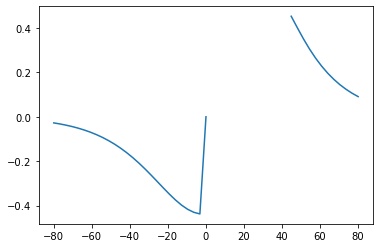

In [71]:
plt.plot(delta_t, d_w_tot)